In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


This script is used to estimate the number of features with strong regulatory action in gastrulation data.

In [ ]:
from IPython import display
import pandas as pd
import numpy as np
import numpy as np
import numpy.ma as ma
import scipy
import scipy.stats
from scipy.stats import gaussian_kde
from scipy.stats import t

from matplotlib import pyplot as plt
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
from matplotlib import cm
from matplotlib.colors import Normalize 
from matplotlib.offsetbox import AnchoredText

from tensorflow import keras
from sklearn.neighbors import KernelDensity

from tensorflow.keras import layers
import tensorflow_probability as tfp
import tensorflow.compat.v2 as tf
tf.enable_v2_behavior()

import pickle
from timeit import default_timer as timer
Folder = '/content/drive/MyDrive/'

Load posterior latent correlations for original and negative control data.

In [ ]:
#To run analysis on the meta-data of the model without inflation, replace files with the commented ones
with open(Folder+'SCRaPL/Real/Results_DIC_col/nuts_cor_gastr_dic_n.pickle','rb')  as handle: #nuts_cor_no_inf_atac
    cor_nuts = pickle.load(handle)
with open(Folder+'SCRaPL/Real/Results_col_neg/nuts_cor_gastr_neg1.pickle', 'rb') as handle: #nuts_cor_atac_ninf_neg1.pickle
    cor_nuts_neg1 = pickle.load(handle)
with open(Folder+'SCRaPL/Real/Results_col_neg/nuts_cor_gastr_neg2.pickle', 'rb') as handle: #nuts_cor_atac_ninf_neg2.pickle
    cor_nuts_neg2 = pickle.load(handle)
with open(Folder+'SCRaPL/Real/Results_col_neg/nuts_cor_gastr_neg3.pickle', 'rb') as handle: #nuts_cor_atac_ninf_neg3.pickle
    cor_nuts_neg3 = pickle.load(handle)
with open(Folder+'SCRaPL/Real/Results_col_neg/nuts_cor_gastr_neg4.pickle', 'rb') as handle: #nuts_cor_atac_ninf_neg4.pickle
    cor_nuts_neg4 = pickle.load(handle)
with open(Folder+'SCRaPL/Real/Results_col_neg/nuts_cor_gastr_neg5.pickle', 'rb') as handle: #nuts_cor_atac_ninf_neg5.pickle
    cor_nuts_neg5 = pickle.load(handle)

In this section we use detected features found in the previous section and estimate features with strong regulator action according to Pearson correlation to draw volcano plots that appear in the main paper.  

In [ ]:
yy_met = pd.read_csv(Folder+'SCRaPL/Real/Data/Met.csv',sep=',',index_col=[0])
yy_exp = pd.read_csv(Folder+'SCRaPL/Real/Data/Rna.csv',sep=',',index_col=[0])
CpG = pd.read_csv(Folder+'SCRaPL/Real/Data/CpG.csv',sep=',',index_col=[0])
nrm = pd.read_csv(Folder+'SCRaPL/Real/Data/nrm_new.csv',sep=',',index_col=[1])

In [ ]:
y_met_np = yy_met.to_numpy()
y_exp_np = yy_exp.to_numpy()
CpG_np = CpG.to_numpy()

CpG_np[CpG_np ==0] = np.nan
y_met_np[np.isnan(CpG_np)] = np.nan
y_exp_np[np.isnan(CpG_np)] = np.nan
num_obs = np.sum(~np.isnan(CpG_np),axis=1)[:,np.newaxis]

met_r = np.divide(y_met_np,CpG_np)
y_exp_nrm_np = np.divide(y_exp_np,np.transpose(nrm.to_numpy())) 

met_mask=ma.masked_invalid(met_r)
exp_mask=ma.masked_invalid(y_exp_nrm_np)
msk =(~met_mask.mask & ~exp_mask.mask)

crr_prs = []
for ii in range(9480):
    tt1 = met_r[ii,:]
    tt2 = y_exp_nrm_np[ii,:]
    ttt1 = np.divide(tt1-np.nanmean(tt1),np.nanstd(tt1,ddof=1))
    ttt2 = np.divide(tt2-np.nanmean(tt2),np.nanstd(tt2,ddof=1))
    crr = np.nansum(np.multiply(ttt1,ttt2))/(num_obs[ii]-1)
    crr_prs.append(crr)

crr_prs = np.asarray(crr_prs,dtype=np.float32)

In [ ]:
#Estimate p values for standard volcano plots.
t_stat  = np.multiply(crr_prs , np.sqrt(np.divide(num_obs-2,np.ones_like(crr_prs)-np.square(crr_prs)))) 
p  = 2*t.cdf(-np.abs(t_stat),num_obs-2)

In [ ]:
#Taken from https://github.com/CoBiG2/cobig_misc_scripts/blob/master/FDR.py
#Author: Francisco Pina Martins <f.pinamartins@gmail.com>
#Taken from https://stackoverflow.com/a/21739593/3091595

def multiple_testing_correction(pvalues, correction_type="FDR"):

    from numpy import array, empty
    pvalues = array(pvalues)
    sample_size = pvalues.shape[0]
    qvalues = empty(sample_size)
    if correction_type == "Bonferroni":
        # Bonferroni correction
        qvalues = sample_size * pvalues
    elif correction_type == "Bonferroni-Holm":
        # Bonferroni-Holm correction
        values = [(pvalue, i) for i, pvalue in enumerate(pvalues)]
        values.sort()
        for rank, vals in enumerate(values):
            pvalue, i = vals
            qvalues[i] = (sample_size-rank) * pvalue
    elif correction_type == "FDR":
        # Benjamini-Hochberg, AKA - FDR test
        values = [(pvalue, i) for i, pvalue in enumerate(pvalues)]
        values.sort()
        values.reverse()
        new_values = []
        for i, vals in enumerate(values):
            rank = sample_size - i
            pvalue, index = vals
            new_values.append((sample_size/rank) * pvalue)
        for i in range(0, int(sample_size)-1):
            if new_values[i] < new_values[i+1]:
                new_values[i+1] = new_values[i]
        for i, vals in enumerate(values):
            pvalue, index = vals
            qvalues[index] = new_values[i]
    return qvalues


In [ ]:
p_adj = multiple_testing_correction(p, correction_type = "FDR")
p_adj_ft = pd.read_csv(Folder+'SCRaPL/Real/Paper_Analysis/Pearson_meta/gastr_p_value_adj.csv', sep=',',header=None).to_numpy()#Load adjusted p-values based on our hypothesis test 
pst_cor_md = tfp.stats.percentile(tf.tanh(cor_nuts/2), 50.0,axis=0, interpolation='midpoint').numpy()  

In [ ]:
scrapl_imp = pd.read_csv(Folder+'SCRaPL/Real/Paper_Analysis/SCRaPL_meta/gastr_feature_ind_neg0.csv', sep=',',header=None).to_numpy()
p_bay_np = pd.read_csv(Folder+'SCRaPL/Real/Paper_Analysis/SCRaPL_meta/gastr_p_bay_neg0.csv', sep=',',header=None).to_numpy()

In [ ]:
prs_imp = np.where(p_adj_ft<0.1)[0]
scrapl_imp = np.where(scrapl_imp>0)[0]
all_ind = np.asarray(np.linspace(0,9480,num=9480,endpoint=False)[:,np.newaxis],dtype=np.int32)

In [ ]:
scrapl_imp_prs_imp = np.asarray(np.intersect1d(scrapl_imp,prs_imp),dtype=np.int32)
scrapl_imp_prs_nimp = np.asarray(np.setdiff1d(scrapl_imp,scrapl_imp_prs_imp),dtype=np.int32)
scrapl_nimp_prs_imp = np.asarray(np.setdiff1d(prs_imp,scrapl_imp_prs_imp),dtype=np.int32)
scrapl_nimp_prs_nimp = np.asarray(np.setdiff1d(np.setdiff1d(all_ind,prs_imp),scrapl_imp),dtype=np.int32)

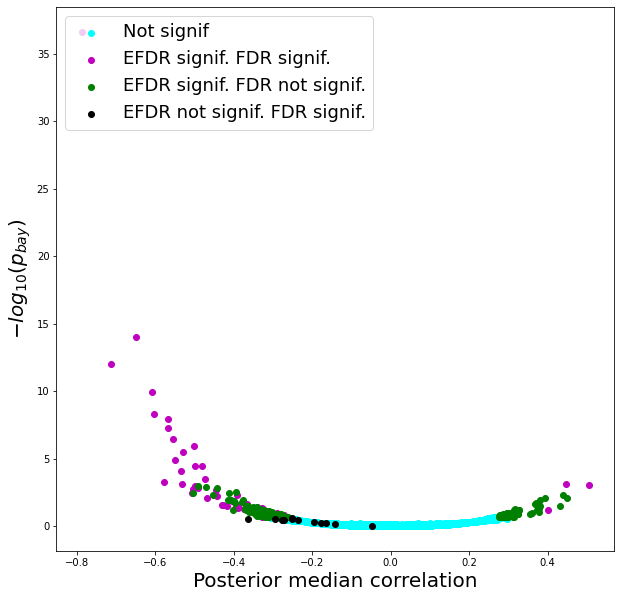

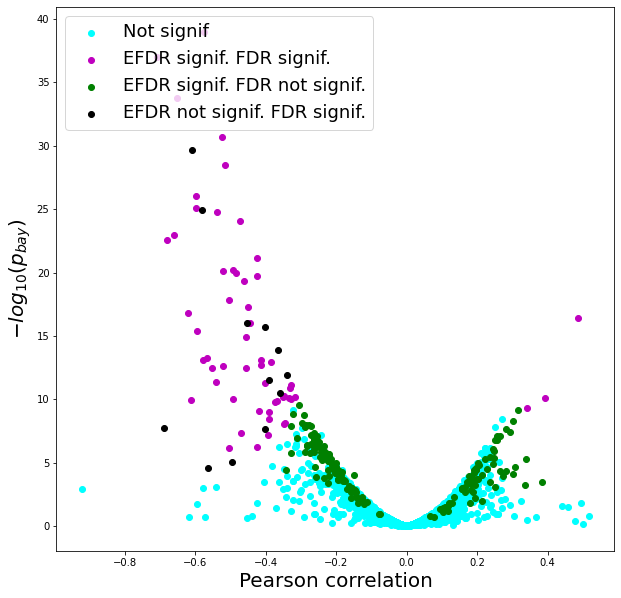

In [ ]:
plt.figure(figsize=(10,10))
plt.scatter(pst_cor_md[scrapl_nimp_prs_nimp],-np.log10(p_bay_np[scrapl_nimp_prs_nimp]),label="Not signif",color = "cyan")
plt.scatter(pst_cor_md[scrapl_imp_prs_imp],-np.log10(p_bay_np[scrapl_imp_prs_imp]),label="EFDR signif. FDR signif.",color='m')
plt.scatter(pst_cor_md[scrapl_imp_prs_nimp],-np.log10(p_bay_np[scrapl_imp_prs_nimp]),label="EFDR signif. FDR not signif.",color="g")
plt.scatter(pst_cor_md[scrapl_nimp_prs_imp],-np.log10(p_bay_np[scrapl_nimp_prs_imp]),label="EFDR not signif. FDR signif.",color='k')
plt.legend(loc="upper left",fontsize=18)
plt.xlabel("Posterior median correlation",fontsize=20)
plt.ylabel(r"$-log_{10}(p_{bay})$",fontsize=20)
plt.savefig(Folder+'SCRaPL/Real/bay_volc_gastr.pdf')
plt.show()

plt.figure(figsize=(10,10))
plt.scatter(crr_prs[scrapl_nimp_prs_nimp],-np.log10(p[scrapl_nimp_prs_nimp]),label="Not signif",color = "cyan")
plt.scatter(crr_prs[scrapl_imp_prs_imp],-np.log10(p[scrapl_imp_prs_imp]),label="EFDR signif. FDR signif.",color='m')
plt.scatter(crr_prs[scrapl_imp_prs_nimp],-np.log10(p[scrapl_imp_prs_nimp]),label="EFDR signif. FDR not signif.",color="g")
plt.scatter(crr_prs[scrapl_nimp_prs_imp],-np.log10(p[scrapl_nimp_prs_imp]),label="EFDR not signif. FDR signif.",color='k')
plt.legend(loc="upper left",fontsize=18)
plt.xlabel("Pearson correlation",fontsize=20)
plt.ylabel(r"$-log_{10}(p_{bay})$",fontsize=20)
plt.savefig(Folder+'SCRaPL/Real/prs_volc_gastr.pdf')
plt.show()